In [75]:
import pandas as pd
import numpy as np  
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import cross_val_score


In [76]:
df = pd.read_excel('premiums_young_with_gr.xlsx')
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount,Genetical_Risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1


In [77]:
df.shape

(20096, 14)

In [78]:
df.columns=df.columns.str.replace(' ', '_').str.lower()
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount', 'genetical_risk'],
      dtype='object')

In [79]:
df.head(1)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4


### Handle NA Values

In [80]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [81]:
df.dropna(inplace=True)

In [82]:
df.isna().sum()
df.shape

(20090, 14)

In [83]:
df.duplicated().sum()

0

In [84]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,20090.0,21.494375,2.294052,18.0,19.00,22.0,23.0,25.0
number_of_dependants,20090.0,0.718019,0.940713,-3.0,0.00,0.0,1.0,3.0
income_lakhs,20090.0,22.510851,23.420493,1.0,6.00,16.0,31.0,790.0
annual_premium_amount,20090.0,8142.096267,2749.906347,3501.0,6022.25,7939.0,9561.0,18186.0
genetical_risk,20090.0,2.503932,1.710203,0.0,1.00,3.0,4.0,5.0


In [85]:
df[df.number_of_dependants<0]["number_of_dependants"].unique()

array([-3, -1], dtype=int64)

In [86]:
df["number_of_dependants"]=abs(df["number_of_dependants"])
df["number_of_dependants"].describe()

count    20090.000000
mean         0.722598
std          0.937200
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: number_of_dependants, dtype: float64

In [87]:
numeric_col=df.columns[df.dtypes!="object"].to_list()
numeric_col

['age',
 'number_of_dependants',
 'income_lakhs',
 'annual_premium_amount',
 'genetical_risk']

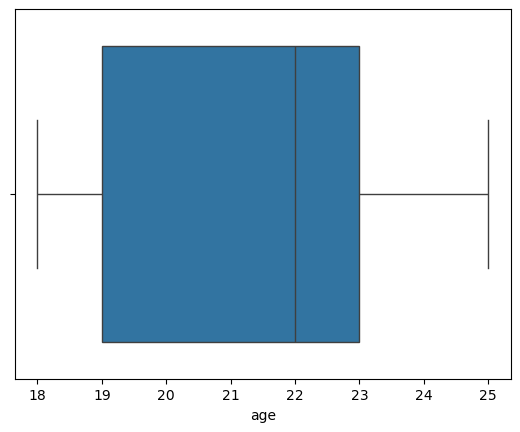

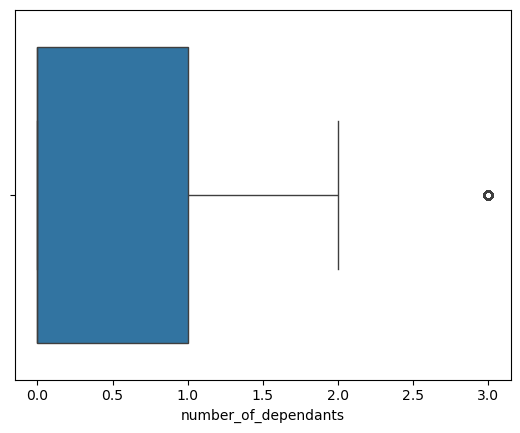

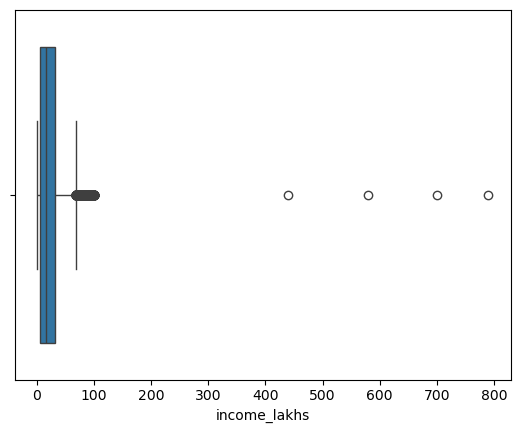

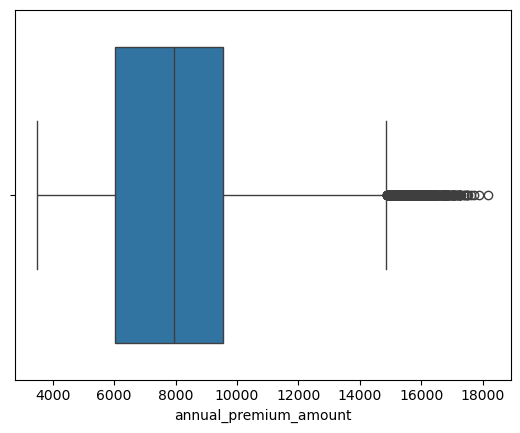

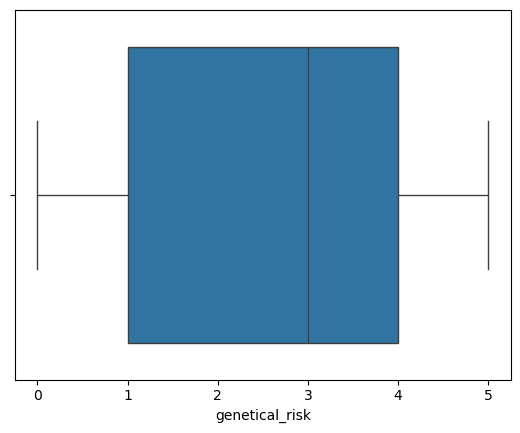

In [88]:
for col in numeric_col:
    sns.boxplot(x=df[col])
    plt.show()

In [89]:
df[df.age>100]["age"].unique()


array([], dtype=int64)

In [90]:
df1=df[df.age<=100].copy()
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
age,20090.0,21.494375,2.294052,18.0,19.00,22.0,23.0,25.0
number_of_dependants,20090.0,0.722598,0.937200,0.0,0.00,0.0,1.0,3.0
income_lakhs,20090.0,22.510851,23.420493,1.0,6.00,16.0,31.0,790.0
annual_premium_amount,20090.0,8142.096267,2749.906347,3501.0,6022.25,7939.0,9561.0,18186.0
genetical_risk,20090.0,2.503932,1.710203,0.0,1.00,3.0,4.0,5.0


In [91]:
def get_iqr_bounce(col):
    Q1,Q3=col.quantile([0.25,0.75])
    IQR=Q3-Q1
    lower_bounce=Q1-1.5*IQR
    upper_bounce=Q3+1.5*IQR
    return lower_bounce, upper_bounce

In [92]:
get_iqr_bounce(df1["income_lakhs"])

(-31.5, 68.5)

In [93]:
Quantile_threshold=df1.income_lakhs.quantile(0.999)
Quantile_threshold

100.0

In [94]:
df2=df1[df1.income_lakhs<=Quantile_threshold].copy()
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
age,20086.0,21.494474,2.294248,18.0,19.0,22.0,23.0,25.0
number_of_dependants,20086.0,0.722742,0.937238,0.0,0.0,0.0,1.0,3.0
income_lakhs,20086.0,22.390371,21.732062,1.0,6.0,16.0,31.0,100.0
annual_premium_amount,20086.0,8141.799263,2749.912486,3501.0,6022.0,7939.0,9561.0,18186.0
genetical_risk,20086.0,2.503883,1.710184,0.0,1.0,3.0,4.0,5.0


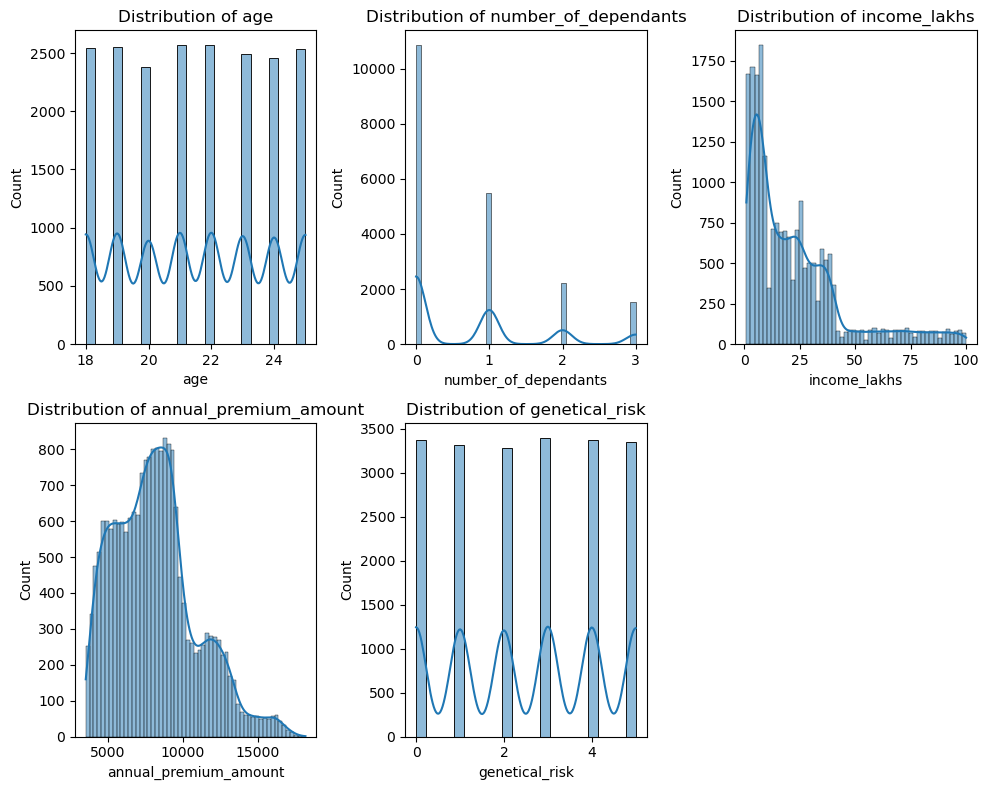

In [96]:
fig,axs=plt.subplots(nrows=2,ncols=3,figsize=(10,8))
for i,col in enumerate(numeric_col):
    ax=axs[i//3,i%3]
    sns.histplot(df2[col], kde=True,ax=ax)
    ax.set_title(f'Distribution of {col}')
if len(numeric_col)%3!=0:
    for j in range(len(numeric_col),6):
        axs.flat[j].set_visible(False)
plt.tight_layout()
plt.show()

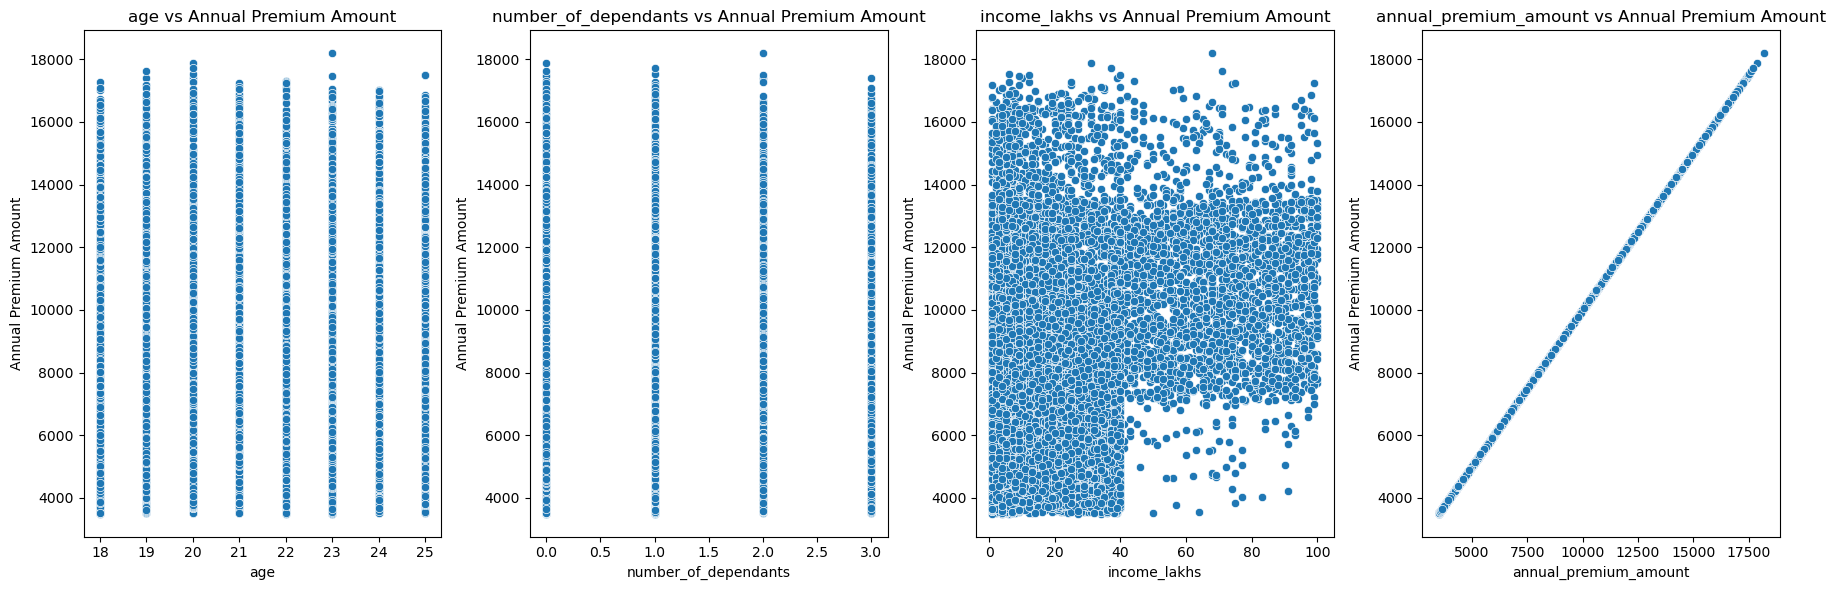

In [97]:
fig,axs=plt.subplots(1,4,figsize=(18,6))
for ax,col in zip(axs,numeric_col):
    
    sns.scatterplot(x=df2[col], y=df2["annual_premium_amount"],ax=ax)
    ax.set_title(f'{col} vs Annual Premium Amount')
    ax.set_xlabel(col)
    ax.set_ylabel("Annual Premium Amount")
plt.tight_layout()
plt.show()

In [23]:
categorical_col=df2.columns[df2.dtypes=="object"].to_list()
categorical_col

['gender',
 'region',
 'marital_status',
 'bmi_category',
 'smoking_status',
 'employment_status',
 'income_level',
 'medical_history',
 'insurance_plan']

In [98]:
for col in categorical_col:
    print(col,":",df2[col].unique())

gender : ['Male' 'Female']
region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan : ['Silver' 'Bronze' 'Gold']


In [99]:
df2["smoking_status"].replace({"Smoking=0":"No Smoking","Does Not Smoke":"No Smoking","Not Smoking":"No Smoking"},inplace=True)

C:\Users\Satya\AppData\Local\Temp\ipykernel_24536\2345664793.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2["smoking_status"].replace({"Smoking=0":"No Smoking","Does Not Smoke":"No Smoking","Not Smoking":"No Smoking"},inplace=True)


In [100]:
df2.smoking_status.unique()

array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

In [101]:
pct_count_gender=df2["gender"].value_counts(normalize=True)

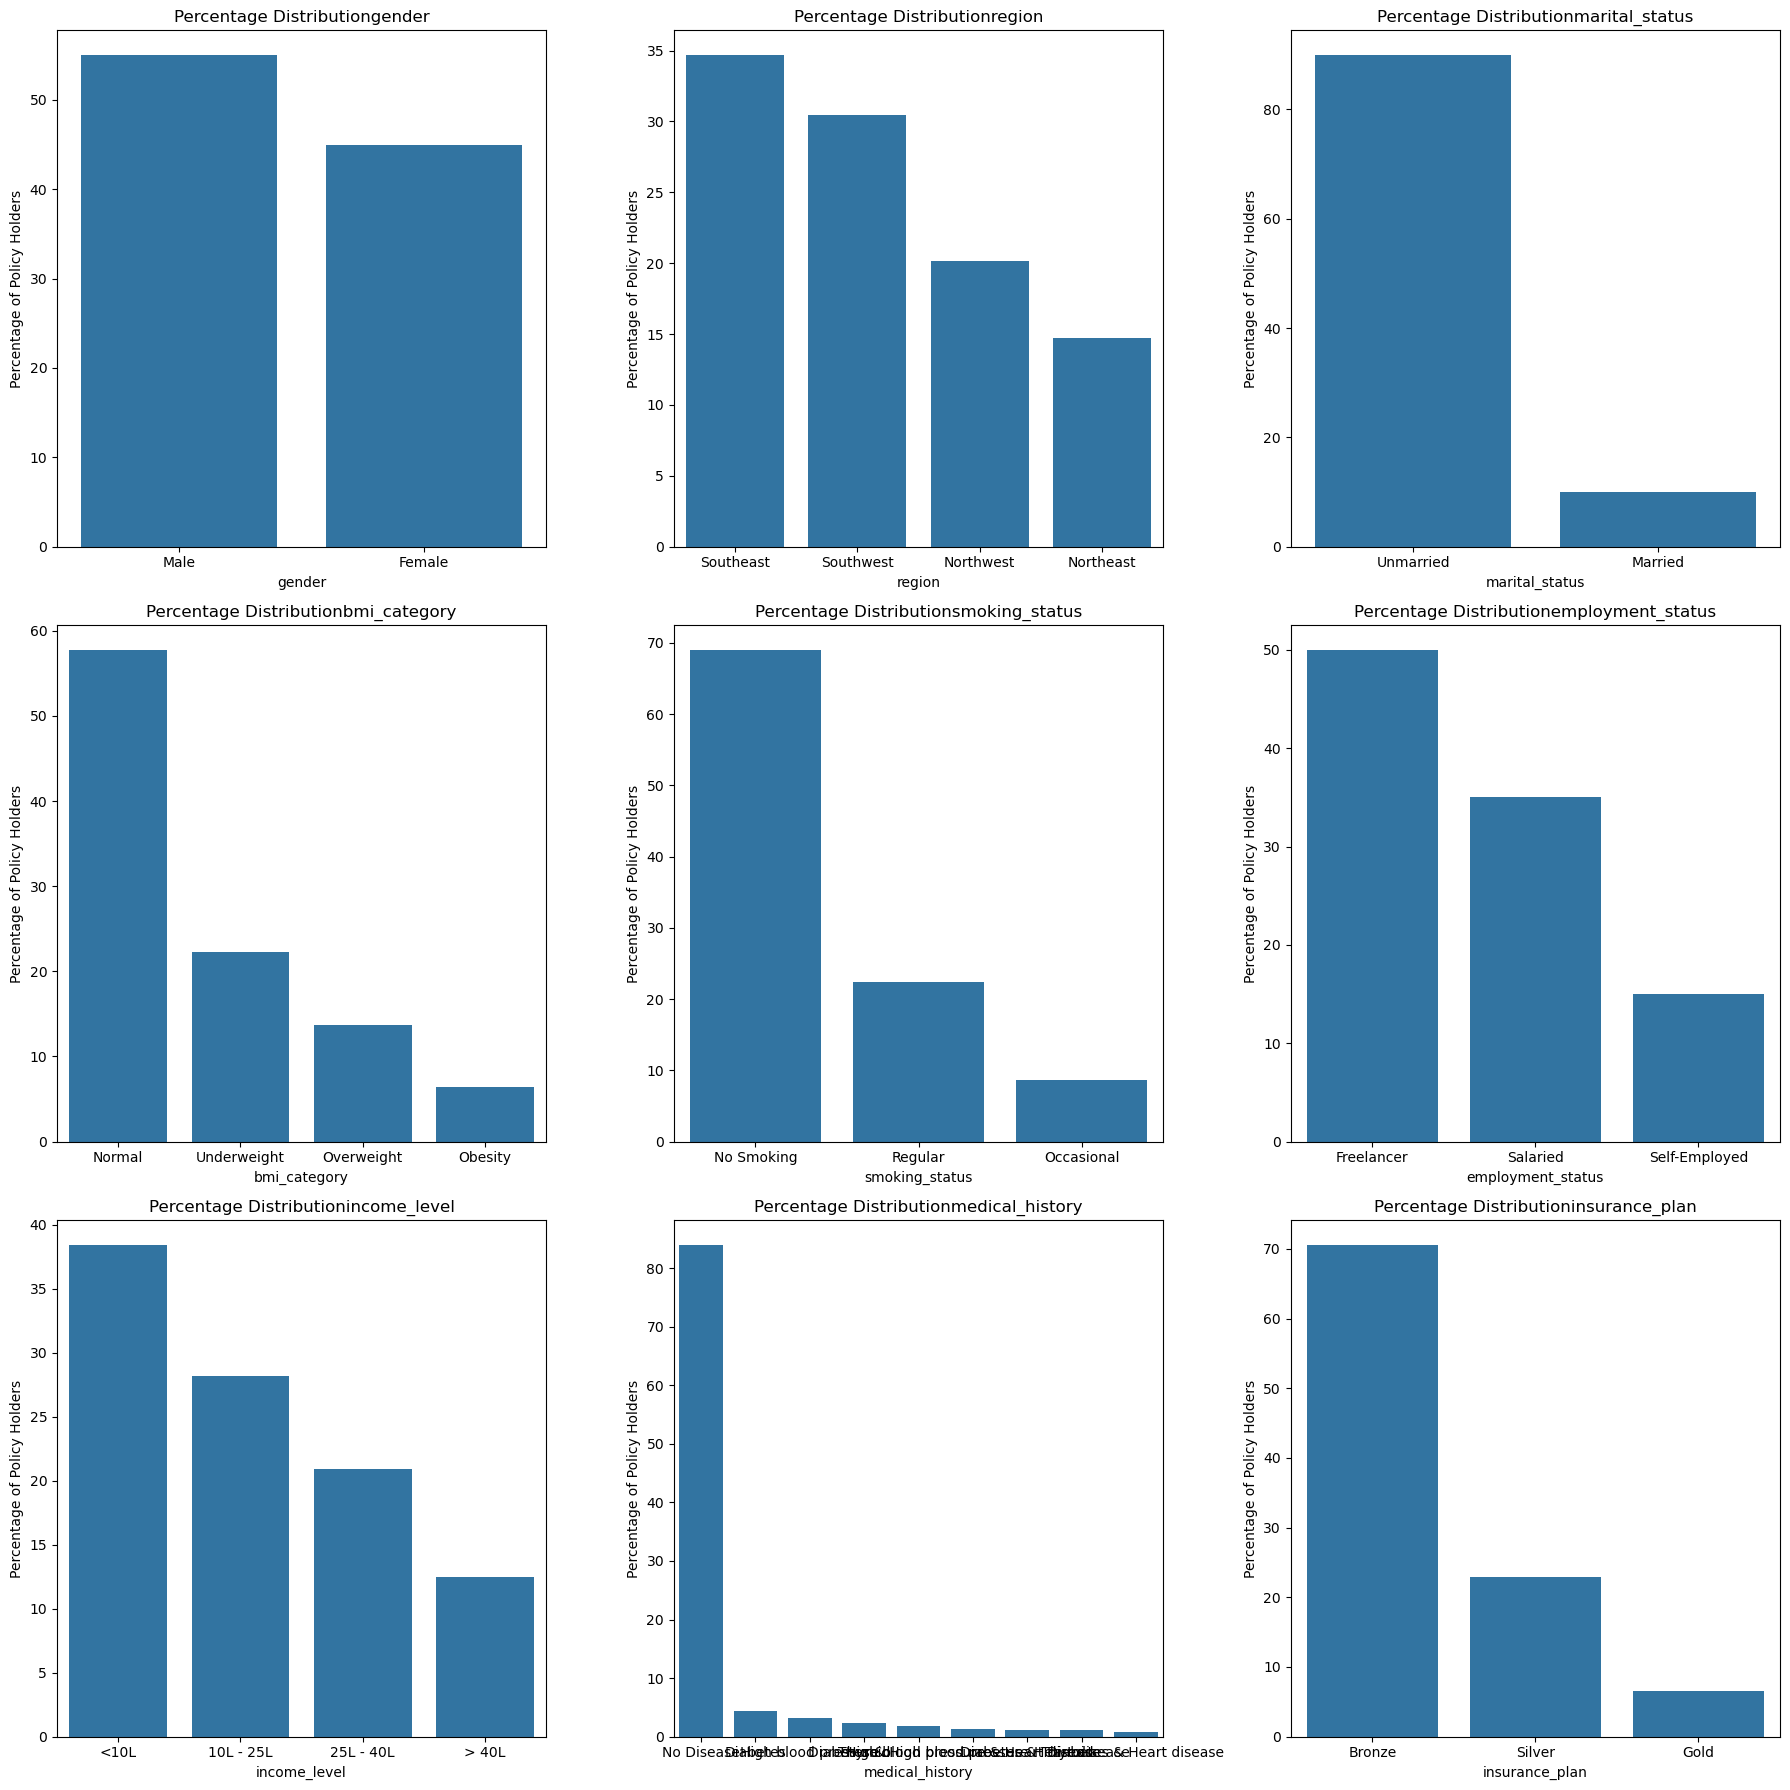

In [102]:
fig,axs=plt.subplots(3,3,figsize=(18,18))
axs = axs.flatten()
for ax,col in zip(axs,categorical_col):
    category_counts=df2[col].value_counts(normalize=True)*100
    
    sns.barplot(x=category_counts.index,y=category_counts.values,ax=ax)
    ax.set_title(f'Percentage Distribution{col}')
    ax.set_xlabel(col)
    ax.set_ylabel("Percentage of Policy Holders")
plt.tight_layout()
plt.show()

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         4508   326     828
25L - 40L         3382   209     608
<10L              6172   404    1145
> 40L              115   366    2023


Text(0.5, 1.0, 'Income Level vs Insurance Plan')

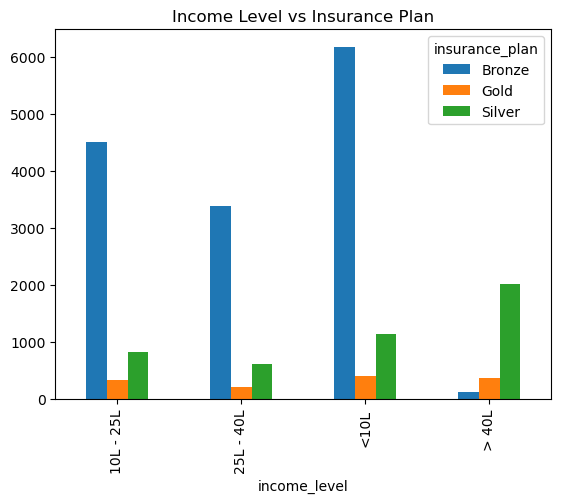

In [103]:
cross_tab=pd.crosstab(df2["income_level"],df2["insurance_plan"])
print(cross_tab)
cross_tab.plot(kind="bar")
plt.title("Income Level vs Insurance Plan")

In [104]:
df2.medical_history.unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

In [31]:
# risk_score={"Diabetes":6,"Heart disease":8,"High blood pressure":6,"Thyroid":5,"No Disease":0,"None":0}
# df2[["disease1","disease2"]]=df2.medical_history.str.split("&",expand=True)
# df2.head(15)

In [105]:
# Define the risk scores for each condition
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

df2[['disease1', 'disease2']] = df2['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

# Normalize the risk score to a range of 0 to 1
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head(15)

C:\Users\Satya\AppData\Local\Temp\ipykernel_24536\2503336130.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['disease1'].fillna('none', inplace=True)
C:\Users\Satya\AppData\Local\Temp\ipykernel_24536\2503336130.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4,no disease,none,0,0.000000
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2,no disease,none,0,0.000000
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1,no disease,none,0,0.000000
5,22,Female,Southwest,Unmarried,0,Underweight,Regular,Freelancer,25L - 40L,30,High blood pressure,Gold,15473,3,high blood pressure,none,6,0.428571
6,19,Male,Southwest,Unmarried,0,Normal,No Smoking,Freelancer,<10L,8,No Disease,Bronze,4097,0,no disease,none,0,0.000000
7,18,Female,Northwest,Unmarried,1,Underweight,No Smoking,Salaried,<10L,5,Diabetes & High blood pressure,Bronze,8187,3,diabetes,high blood pressure,12,0.857143
8,23,Male,Northwest,Unmarried,0,Underweight,No Smoking,Salaried,<10L,8,No Disease,Bronze,5387,1,no disease,none,0,0.000000
9,20,Female,Northeast,Unmarried,0,Normal,Occasional,Salaried,10L - 25L,18,No Disease,Bronze,8866,5,no disease,none,0,0.000000


### Yha se krna hai

In [33]:
# df2["disease1"].fillna("None",inplace=True)
# df2["disease2"].fillna("None",inplace=True)
# df2["Total_risk_score"]=0
# for disease in ["disease1","disease2"]:
#     df2["Total_risk_score"]+=df2[disease].map(risk_score)
# max_score=df2["Total_risk_score"].max()
# min_score=df2["Total_risk_score"].min()
# df2["normalized_risk_score"]=(df2["Total_risk_score"]-min_score)/(max_score-min_score)
# df2.head(15)

In [34]:
# max_score

In [106]:
df2.insurance_plan.unique()

array(['Silver', 'Bronze', 'Gold'], dtype=object)

In [107]:
df2["insurance_plan"]=df2["insurance_plan"].map({"Bronze":1,"Silver":2,"Gold":3})


In [108]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,2,13365,4,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,2,11050,3,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,2,11857,4,no disease,none,0,0.000000
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,1,5684,2,no disease,none,0,0.000000
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,1,5712,1,no disease,none,0,0.000000


In [109]:
df2.insurance_plan.unique()

array([2, 1, 3], dtype=int64)

In [110]:
df2.income_level.unique()

array(['> 40L', '<10L', '10L - 25L', '25L - 40L'], dtype=object)

In [111]:
df2["income_level"]=df2["income_level"].map({"<10L":1,"10L - 25L":2,"> 40L":4,"25L - 40L":3})
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,4,99,High blood pressure,2,13365,4,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,1,3,No Disease,2,11050,3,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,4,97,No Disease,2,11857,4,no disease,none,0,0.000000
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,2,15,No Disease,1,5684,2,no disease,none,0,0.000000
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,2,14,No Disease,1,5712,1,no disease,none,0,0.000000


In [112]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head(3)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,High blood pressure,2,13365,4,high blood pressure,none,...,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,No Disease,2,11050,3,no disease,none,...,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,No Disease,2,11857,4,no disease,none,...,1,0,1,0,0,0,0,1,1,0


In [113]:
df4=df3.drop(["medical_history","disease1","disease2","total_risk_score"],axis=1)
df4.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,4,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,3,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,2,11857,4,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,25,0,2,15,1,5684,2,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,20,2,2,14,1,5712,1,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


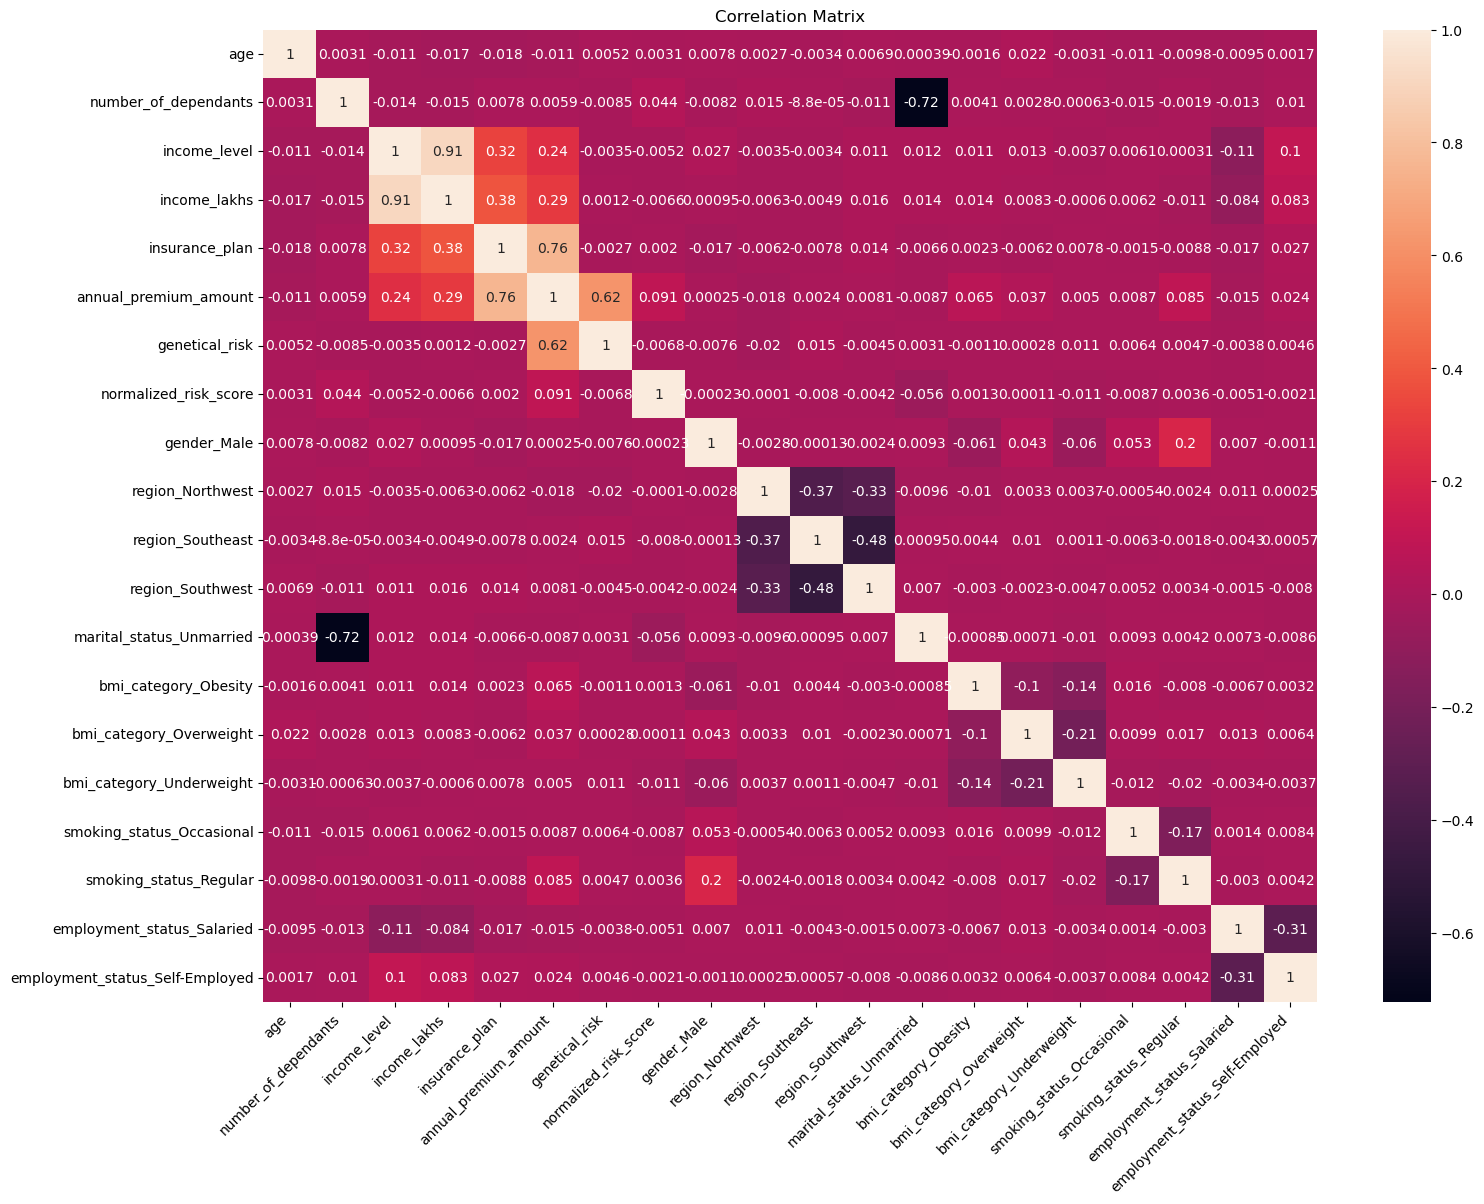

In [114]:
cm=df4.corr()
plt.figure(figsize=(16,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45,ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.title("Correlation Matrix") 

plt.show()

In [115]:
df4.head(2)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,4,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,3,0.000000,0,1,0,0,1,0,0,1,0,0,0,0


In [116]:
X=df4.drop("annual_premium_amount",axis="columns")
y=df4["annual_premium_amount"]
from sklearn.preprocessing import MinMaxScaler
cols_to_scale=["age","number_of_dependants","income_level","income_lakhs","insurance_plan"]
scaler=MinMaxScaler()
X[cols_to_scale]=scaler.fit_transform(X[cols_to_scale])
X.head(2)
X.describe()


,age,number_of_dependants,income_level,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,0.499211,0.240914,0.357994,0.216064,0.179578,2.503883,0.092076,0.550383,0.201284,0.346958,0.304590,0.899881,0.063527,0.136513,0.222493,0.086379,0.223589,0.350045,0.149955
std,0.327750,0.312413,0.347481,0.219516,0.300051,1.710184,0.230016,0.497467,0.400970,0.476014,0.460245,0.300167,0.243914,0.343341,0.415931,0.280929,0.416660,0.476996,0.357036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.000000,0.050505,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.571429,0.000000,0.333333,0.151515,0.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.333333,0.666667,0.303030,0.500000,4.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [117]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [118]:
calculate_vif(X)

,Column,VIF
0,age,3.154599
1,number_of_dependants,1.930428
2,income_level,11.928708
3,income_lakhs,11.876413
4,insurance_plan,1.592966
5,genetical_risk,2.981159
6,normalized_risk_score,1.154501
7,gender_Male,2.311831
8,region_Northwest,2.154355
9,region_Southeast,2.990493


In [119]:
calculate_vif(X.drop('income_level', axis="columns"))

,Column,VIF
0,age,3.153255
1,number_of_dependants,1.927788
2,income_lakhs,2.294155
3,insurance_plan,1.587868
4,genetical_risk,2.981158
5,normalized_risk_score,1.154453
6,gender_Male,2.301658
7,region_Northwest,2.153423
8,region_Southeast,2.989301
9,region_Southwest,2.743932


In [120]:
X_reduced=X.drop('income_level', axis="columns")
X_reduced.head(2)

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,0.989899,0.5,4,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.0,0.020202,0.5,3,0.000000,0,1,0,0,1,0,0,1,0,0,0,0


### Model Training

In [121]:
x_train,x_test,y_train,y_test=train_test_split(X_reduced, y, test_size=0.3, random_state=10)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(14060, 18) (6026, 18) (14060,) (6026,)


In [122]:
Lr=LinearRegression()
Lr.fit(x_train,y_train)
test_score=Lr.score(x_test,y_test)
train_score=Lr.score(x_train,y_train)
print("Test Score:",test_score)
print("Train Score:",train_score)

Test Score: 0.9887263253056615
Train Score: 0.988297900194864


In [123]:
x_test.head(2)

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
12774,1.000000,0.666667,0.040404,0.0,2,0.0,1,0,0,1,1,0,0,1,0,0,0,0
14758,0.285714,0.000000,0.060606,0.0,5,0.0,0,0,0,1,1,0,0,0,0,1,0,1


In [124]:
Lr.coef_

array([-7.22903185e+00,  1.95361819e+01, -1.26452776e+00,  7.00112526e+03,
        9.99397746e+02,  1.10914836e+03,  8.17798831e+00,  1.67735268e+00,
       -3.27532710e+00,  6.31709531e+00,  1.60689716e+01,  8.12844929e+02,
        4.00375598e+02,  1.07529819e+02,  2.05069661e+02,  6.10983280e+02,
        3.87836470e-02, -5.24201812e+00])

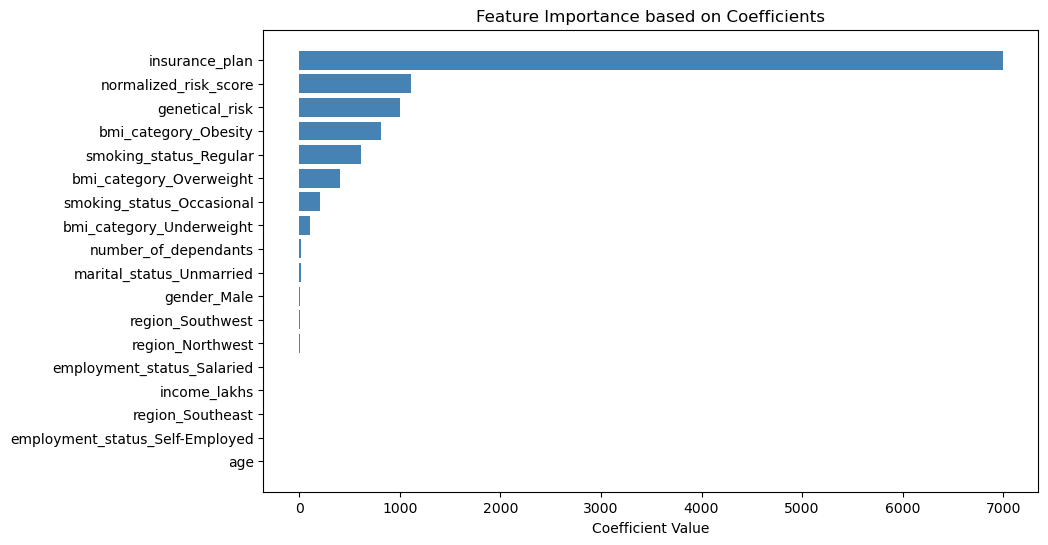

In [126]:
features_importance=Lr.coef_
coef_df=pd.DataFrame(features_importance,index=x_test.columns,columns=["Coefficients"])
coef_df=coef_df.sort_values(by="Coefficients", ascending=True)



plt.figure(figsize=(10,6))
plt.barh(coef_df.index, coef_df['Coefficients'],color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance based on Coefficients')
plt.show()


In [127]:
Lr.intercept_

3978.823528438259

In [128]:
model_ridge=Ridge()
model_ridge.fit(x_train,y_train)
test_score=model_ridge.score(x_test,y_test)
train_score=model_ridge.score(x_train,y_train)
print("Test Score:",test_score)
print("Train Score:",train_score)

Test Score: 0.9887266341700511
Train Score: 0.9882974390415337


In [129]:
model_lasso=Lasso()
model_lasso.fit(x_train,y_train)
test_score=model_lasso.score(x_test,y_test)
train_score=model_lasso.score(x_train,y_train)
print("Test Score:",test_score)
print("Train Score:",train_score)

Test Score: 0.9887361266518101
Train Score: 0.9882804513679263


In [130]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=10)
xgb_model.fit(x_train, y_train)
test_score=xgb_model.score(x_test,y_test)
train_score=xgb_model.score(x_train,y_train)
print("Test Score:",test_score)
print("Train Score:",train_score)

Test Score: 0.987729549407959
Train Score: 0.9925054907798767


In [131]:
y_pred=xgb_model.predict(x_test)
mse_lr=mean_squared_error(y_test,y_pred)
rmse_lr=np.sqrt(mse_lr)
print(f"XGBoost Regression ==> MSE:,{mse_lr} RMSE: {rmse_lr}")

XGBoost Regression ==> MSE:,93312.69206188193 RMSE: 305.4712622520847


In [132]:
from sklearn.model_selection import RandomizedSearchCV
model_xgb=XGBRegressor()
param_grid={
    'n_estimators':[20,40,50],
    'learning_rate':[0.01,0.1,0.2],
    'max_depth':[3,4,5],
   
}
random_search=RandomizedSearchCV(estimator=model_xgb,param_distributions=param_grid,n_iter=10,cv=3,scoring="r2",random_state=42,n_jobs=-1)
random_search.fit(x_train,y_train)
best_model=random_search.best_score_
print("Best Model:",best_model)

Best Model: 0.9879226088523865


In [133]:
best_model=Lr

In [134]:
features_importance=best_model.feature_importances_
coef_df=pd.DataFrame(features_importance,index=x_test.columns,columns=["Coefficients"])
coef_df=coef_df.sort_values(by="Coefficients", ascending=True)



plt.figure(figsize=(10,6))
plt.barh(coef_df.index, coef_df['Coefficients'],color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance based on XGBoost')
plt.show()

AttributeError: 'LinearRegression' object has no attribute 'feature_importances_'

### Error Analysis

In [135]:
y_pred=best_model.predict(x_test)
residuals=y_test-y_pred
residual_pct=residuals*100/y_test
result_df=pd.DataFrame(
    {
        "actual":y_test,
        "predicted":y_pred,
        "diff":residuals,
        "diff_pct":residual_pct
    }
)
result_df.head()

,actual,predicted,diff,diff_pct
12774,6238,6121.456891,116.543109,1.868277
14758,9462,9601.797510,-139.797510,-1.477463
13205,5152,5611.056493,-459.056493,-8.910258
14278,6988,7423.486322,-435.486322,-6.231916
19351,4917,5112.056543,-195.056543,-3.966983


<Axes: xlabel='diff_pct', ylabel='Count'>

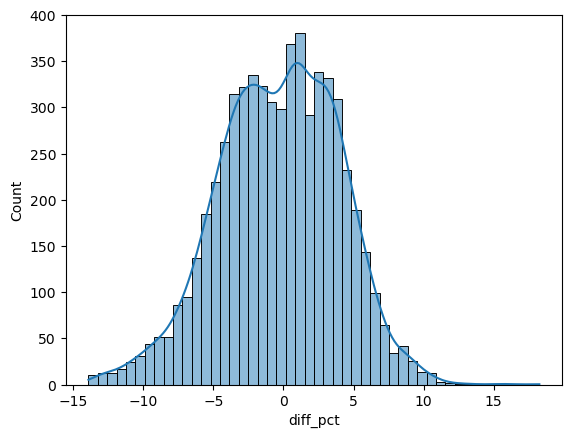

In [136]:
sns.histplot(result_df["diff_pct"],kde=True)

In [137]:
extreme_error_threshold=10
extreme_result_df=result_df[np.abs(result_df.diff_pct)>extreme_error_threshold]
extreme_result_df.shape

(129, 4)

In [138]:
extreme_error_pct=extreme_result_df.shape[0]*100/result_df.shape[0]
extreme_error_pct

2.140723531364089

In [139]:
result_df[np.abs(result_df.diff_pct)>50].sort_values("diff_pct",ascending=False)

,actual,predicted,diff,diff_pct


In [140]:
x_test.index

Index([12774, 14758, 13205, 14278, 19351, 10622, 16391, 14799, 17184, 16348,
       ...
        8695,  9658, 14195,  1365,   399, 17652,  5807, 10298, 13316,  2583],
      dtype='int64', length=6026)

In [141]:
extreme_result_df.index

Index([12669,  2918, 17084,  7181, 12285, 13476, 15481,  2948,  4919, 15170,
       ...
       15166, 19580, 15664,  4204,  8692,  1986,  8008,  9714,  7357,  1534],
      dtype='int64', length=129)

In [142]:
extreme_erorr_df=x_test.loc[extreme_result_df.index]
extreme_erorr_df

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
12669,0.857143,0.000000,0.000000,0.0,0,0.000000,1,0,1,0,1,0,1,0,0,0,1,0
2918,0.285714,0.000000,0.151515,0.0,1,0.000000,1,1,0,0,1,0,0,0,0,0,1,0
17084,1.000000,0.000000,0.353535,0.0,0,0.000000,1,0,0,0,1,0,0,0,0,0,0,0
7181,0.571429,0.000000,0.161616,0.0,0,0.000000,1,0,0,1,1,0,0,0,0,0,0,0
12285,0.428571,0.333333,0.232323,0.0,0,0.000000,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1986,0.000000,0.000000,0.161616,0.0,1,0.000000,0,0,1,0,1,0,0,1,0,0,0,0
8008,0.285714,0.000000,0.242424,0.0,1,0.000000,1,1,0,0,1,0,1,0,0,0,0,0
9714,0.142857,0.000000,0.313131,0.0,0,0.000000,1,0,0,0,1,0,0,0,0,0,1,0
7357,1.000000,0.666667,0.000000,0.0,3,0.571429,1,1,0,0,1,0,0,0,0,0,0,0


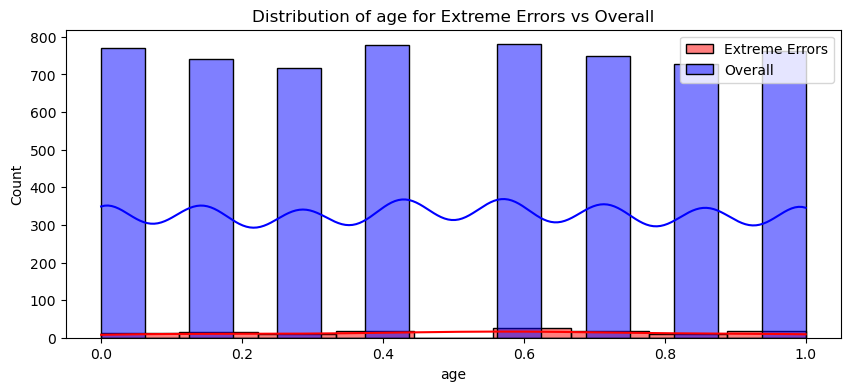

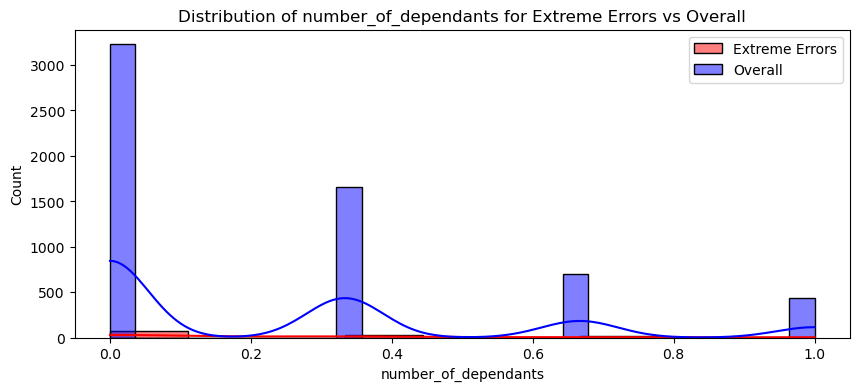

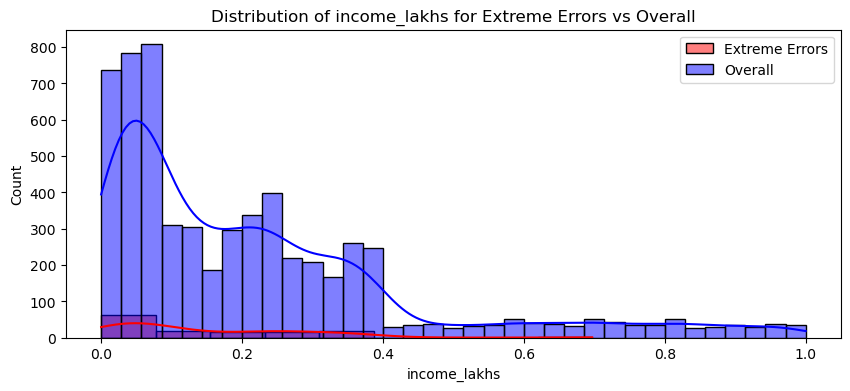

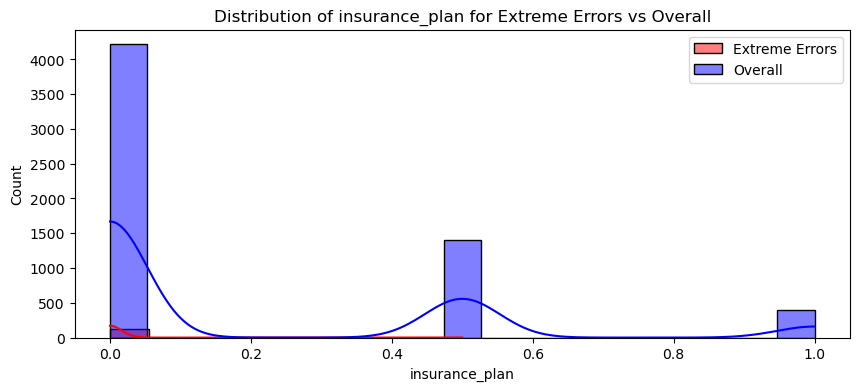

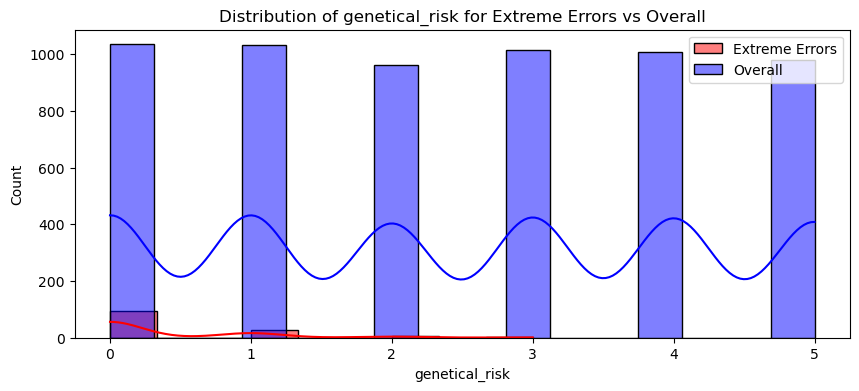

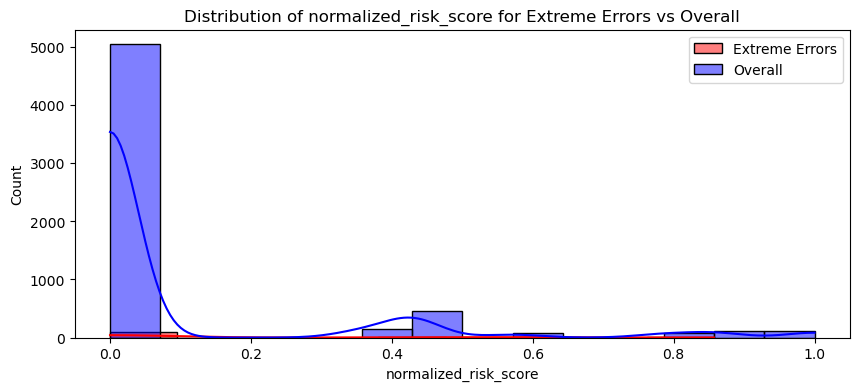

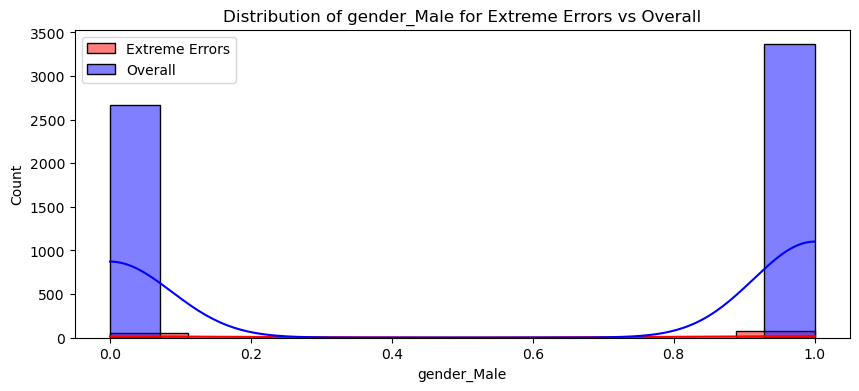

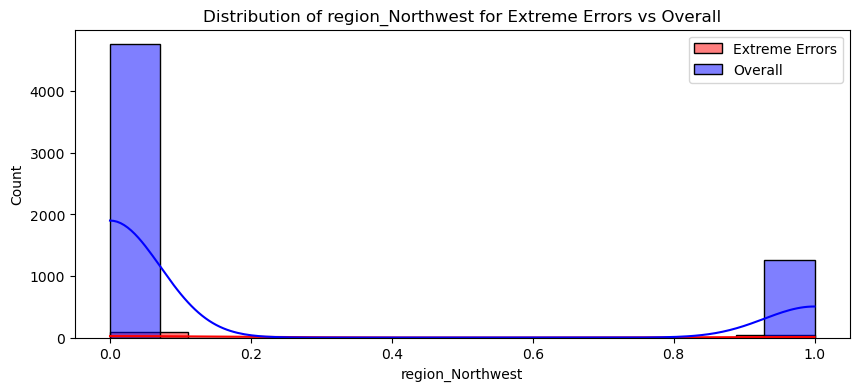

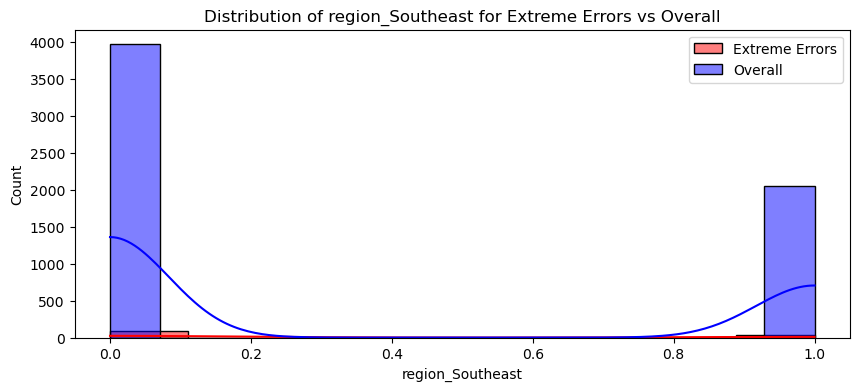

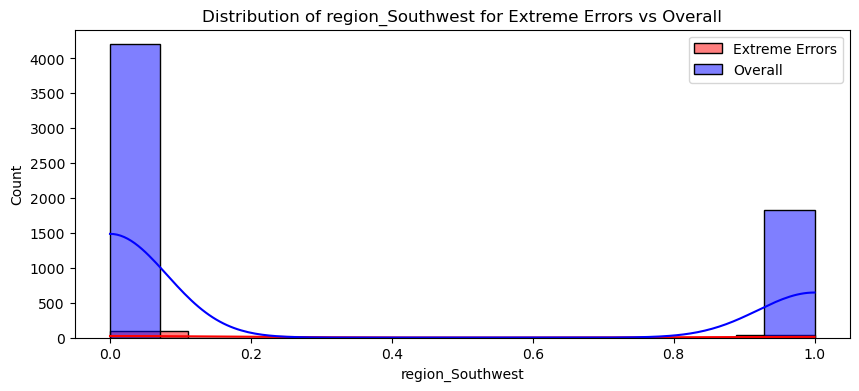

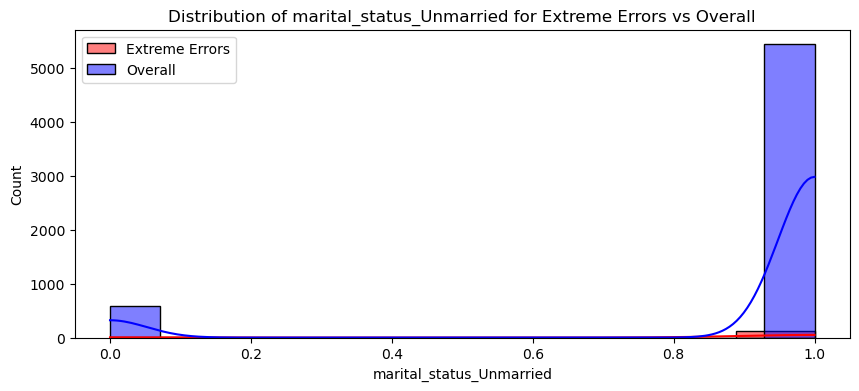

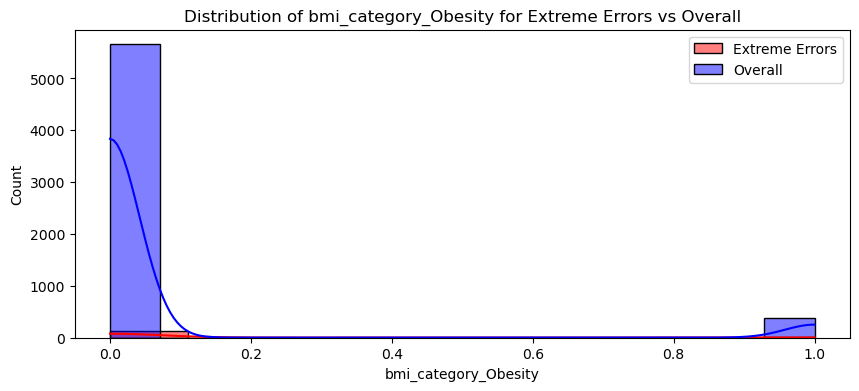

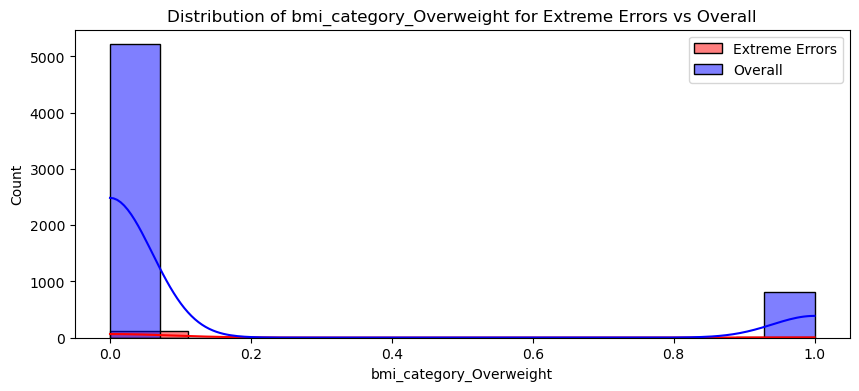

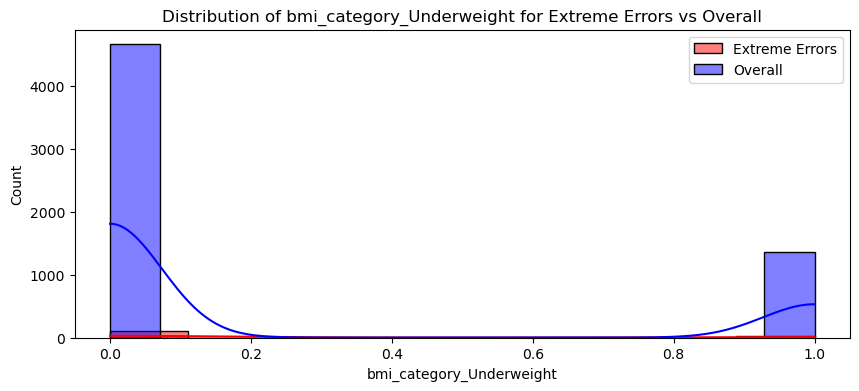

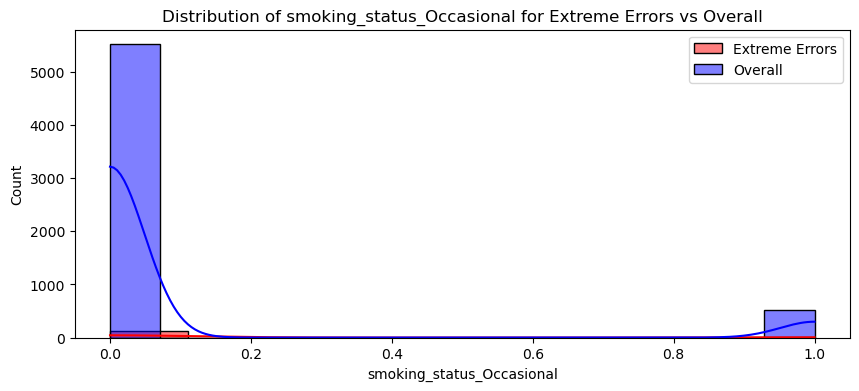

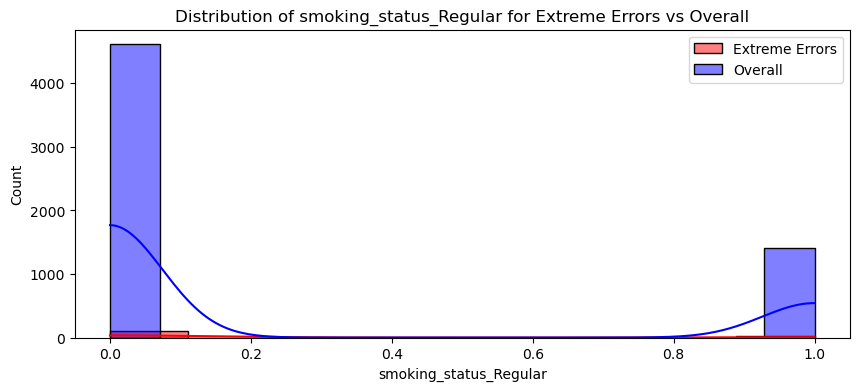

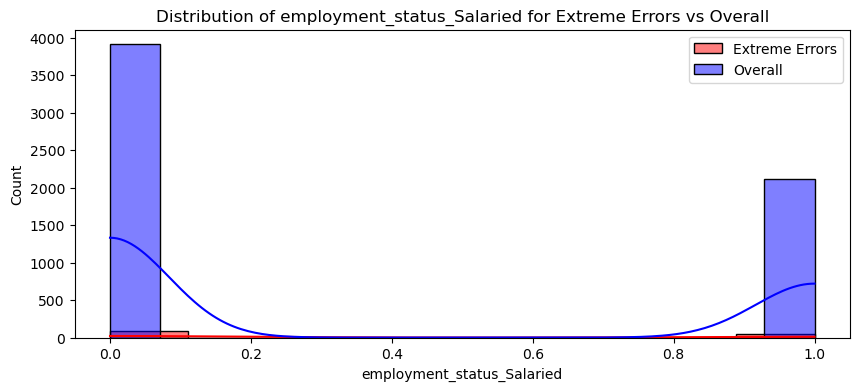

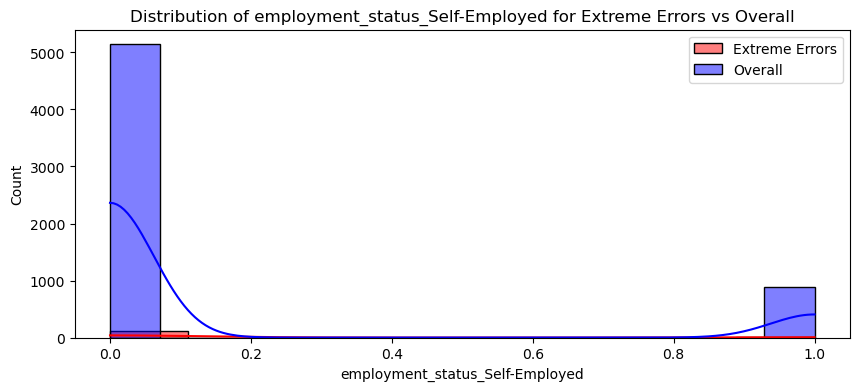

In [143]:
for feature in x_test.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(extreme_erorr_df[feature], color='red', label='Extreme Errors', kde=True)
    sns.histplot(x_test[feature], color='blue', label='Overall', alpha=0.5, kde=True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.show()

In [144]:
extreme_erorr_df["income_level"]=-1

<Axes: xlabel='age', ylabel='Count'>

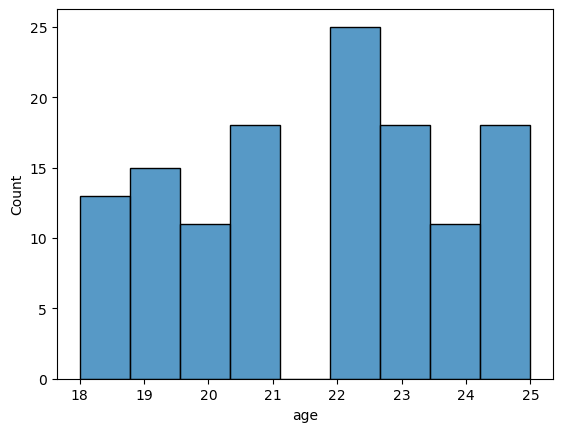

In [145]:
df_reversed=pd.DataFrame()

df_reversed[cols_to_scale]=scaler.inverse_transform(extreme_erorr_df[cols_to_scale])
sns.histplot(df_reversed.age)

##  Exporting Model

In [151]:
from joblib import dump
dump(best_model,"artifact/model_young.joblib")
scaler_with_cols={
    "scaler":scaler,
    "cols_to_scale":cols_to_scale   }
dump(scaler_with_cols,"artifact/scaler_young.joblib")

['artifact/scaler_young.joblib']

In [150]:
scaler_with_cols={
    "scaler":scaler,
    "cols_to_scale":cols_to_scale   }
print(scaler_with_cols)

{'scaler': MinMaxScaler(), 'cols_to_scale': ['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan']}
